In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import datetime as dt
import os
import seaborn as sns
import scipy.stats as sts

import random
import string

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from nb_vars import FOLDER_INTERMEDIATE, FOLDER_OUTPUT, CUTOFF_SPIKES_HZ

## Load df of filtered peaks

In [ ]:
CONDITION_NAME = "pulse_duration"
CONDITION = "200"

In [ ]:
df_peaks = pd.read_csv(f'{FOLDER_INTERMEDIATE}/df_peaks_full_{CONDITION_NAME}_{CONDITION}_freq_{CUTOFF_SPIKES_HZ}.csv')

In [ ]:
df_peaks

## Analysis of burst frequency

The burst frequency is analysed using a sliding window of 0.1 seconds (or any other measure), and selecting timepoint sets where there is a relevant increase in summed signal. To find a threshold we are going to use a knee method of the distribution of the signal.

In [ ]:
from kneed import DataGenerator, KneeLocator

The analysis of burst frequency produces a list of the putative bursts; and for each burst it shows the interval (begin - end) and the point with maximum signal. We also retrieve the number of counts at the peak, and the area of the peak. To compute these points we follow these steps:
1) We divide the time into windows with length `TW`. `TW` = 0.02 records the sum of spikes within each 20 ms. For each window we also compute the mean time to have a n-sized list (the list fo windows is n+1).
2) We count the number of events laying in the window, across all selected electrodes. To normalise the signal, we divide the number of counts by the number of active electrodes and by `TW` (so we obtain a **number of counts per electrode and per second**). This normalisation step is not necessary, but for intermediate checks and comparisons between wells might be useful. It is also useful to compare results with different `TW` values. In any case, this step does not affect the overall number of detected peaks. 
3) To select a cutoff that is not the same for all wells, we are going to use a knee method. If we plot the number of counts using their rank, we get a interesting distribution: 

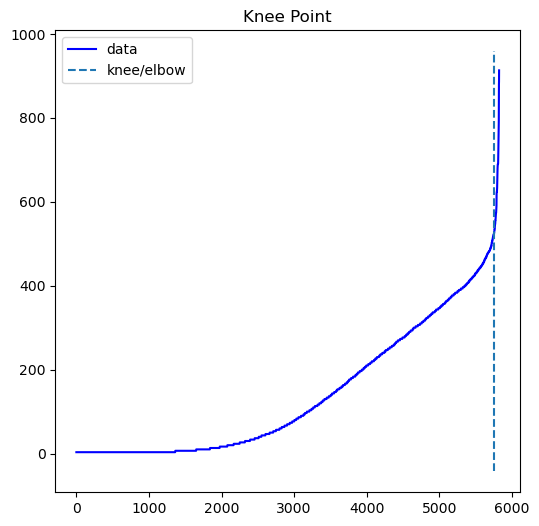

There are only a few points with a lot of signal, which is the cutoff of the method. On the other end we get a lot of points with almost no signal (these are likely noise and the extremes of the peaks). Then in the middle we get a slope without curve, that represent most of the peaks. Because the peaks are "likely" to be triangular, there is no curve; which means a positive and a negative thing. A positive thing is that most of the peaks are already defined and, when we lower the threshold, what we are really doing is just selecting a broader area of the peak, and not newer peaks. The negative part is that getting a decent cutoff is not that easy, and the true cutoff will be arbitrary.  

Therefore, the "true" cutoff will be `PER_MIN` * CUTOFF. This `PER_MIN`value is arbitrary, but a value between 0.05 and 0.2 covers all the relevant bursts without merging individual but really joint bursts. 

4) With cutoff points, bursts are defined as time sets where all points exists (that is, at time t, t+1, t+2, ..., t+n the counts have to be higher than the cutoff). 
5) Interval merging: if two intervals are separated by less than `SEP`, they are merged. This may be because two separate intervals are in fact one joint interval, but because the signal is not so high, it is divided in two intervals.
6) If the length of the interval (in timepoints) is smaller than `MIN_INTERVAL`, the interval is discarded. This is to make sure that bursts with very small timesets are discarded. These burst may have lower signals and are likely to be a result of noise or be present in few electrodes.
7) `TW`rescaling: to save the data of times for each interval and peak point, the results are multiplied by `TW`to convert from timeframe to time. This is interesting because we can use different `TW` values and compare the similarity of the results.

In [ ]:
TW= 0.01
PER_MIN = 0.10
SEP, MIN_INTERVAL = 15, 7


df_burst = pd.DataFrame(columns=['well', 'condition', 'replicate', 'burst_peak', 'peak_val', 'burst_interval', 'interval_length', 'interval_sum', 'interval_diff'])

list_wells = df_peaks['well'].drop_duplicates().values
list_conditions = df_peaks.drop_duplicates('well')['condition']
list_replicates = df_peaks.drop_duplicates('well')['replicate']

for well, condition, replicate in zip(list_wells, list_conditions, list_replicates):
    df_peaks_well = df_peaks[df_peaks['well'] == well]

    # Divide by TW into even-sized window frames.
    time_ranges = np.arange(np.min(df_peaks_well['time']) , np.max(df_peaks_well['time']) , TW)
    time_ranges_mean = (time_ranges[1:] + time_ranges[:-1]) * 0.5 

    # Compute counts and normalize
    counts = np.array([len(df_peaks_well[(df_peaks_well['time'] >= start) & (df_peaks_well['time'] < end)]) for start, end in zip(time_ranges[:-1], time_ranges[1: ])], dtype=np.float64)
    counts /= (len(df_peaks_well.electrode.drop_duplicates()) * TW)

    # Find Knee point
    kneedle = KneeLocator(np.arange(len(counts[counts>0])) , np.sort(counts[counts>0]) , S=4.0, curve="convex", direction="increasing")
    # kneedle.plot_knee()
    cutoff_min = PER_MIN * kneedle.knee_y

    # Select the positive times
    data = counts>cutoff_min

    # Create the intervals
    change_indices = np.diff(data, prepend=0, append=0)

    start_indices = np.where(change_indices == 1)[0]
    end_indices = np.where(change_indices == -1)[0] - 1
    intervals = list(zip(start_indices, end_indices))

    # Merge intervals
    merged_intervals = []
    current_start, current_end = intervals[0]

    for start, end in intervals[1:]:
        if start - current_end - 1 < SEP:
            current_end = end
        else:
            merged_intervals.append((current_start, current_end))
            current_start, current_end = start, end

    merged_intervals.append((current_start, current_end))

    # Remove intervals shorter than MIN_INTERVAL
    filtered_intervals = [(start, end) for start, end in merged_intervals if end - start + 1 >= MIN_INTERVAL]

    max_count_indices = []
    for start, end in filtered_intervals:
        max_index_within_interval = start + np.argmax(counts[start:end + 1])
        max_count_indices.append(max_index_within_interval)

    max_count_indices = np.array(max_count_indices)
    
    # Apply TW reescaling
    interval_sums = [counts[a:b].sum() for (a,b) in filtered_intervals]
    filtered_intervals = [(time_ranges[a] + TW/2 , time_ranges[b] + TW/2) for (a,b) in filtered_intervals]
    interval_lengths = [b-a for (a,b) in filtered_intervals]
    interval_diff = [filtered_intervals[0][0]] + [filtered_intervals[idx + 1][0] - filtered_intervals[idx][1] for idx in range(len(filtered_intervals) - 1)]
    
    peak_vals = counts[max_count_indices]
    max_count_indices = time_ranges[max_count_indices] + TW/2

    iloc_diff = len(max_count_indices)

    df_burst_i = pd.DataFrame({'well': [well] * iloc_diff, 'condition': [condition] * iloc_diff, 'replicate': [replicate] * iloc_diff, 
                               'burst_peak': max_count_indices, 'peak_val': peak_vals, 'burst_interval': filtered_intervals, 'interval_length': interval_lengths, 'interval_sum': interval_sums, 'interval_diff': interval_diff})

    df_burst = pd.concat([df_burst, df_burst_i])

In [ ]:
df_burst

In [ ]:
df_peaks

In [ ]:
well = 'A1'

df_peaks_well = df_peaks[df_peaks['well'] == well]
df_burst_well = df_burst[df_burst['well'] == well]

# Divide by TW into even-sized window frames.
time_ranges = np.arange(np.min(df_peaks_well['time']) , np.max(df_peaks_well['time']) , TW)
time_ranges_mean = (time_ranges[1:] + time_ranges[:-1]) * 0.5 

# Compute counts and normalize
counts = np.array([len(df_peaks_well[(df_peaks_well['time'] >= start) & (df_peaks_well['time'] < end)]) for start, end in zip(time_ranges[:-1], time_ranges[1: ])], dtype=np.float64)
counts /= (len(df_peaks_well.electrode.drop_duplicates()) * TW)


In [ ]:
cutoff_min

In [ ]:
fig = px.scatter(x=df_burst_well['burst_peak'], y=[-0.05 * np.max(counts)] * len(df_burst_well))


for interval in df_burst_well['burst_interval'].values:
    fig.add_trace(go.Scatter(x=interval, y=[-0.02 * np.max(counts)] * 2, mode="lines"))

fig.add_trace(go.Scatter(x=time_ranges_mean, y=counts, mode="lines"))

In [ ]:
fig = px.scatter(x=df_peaks_well['time'], y=((df_peaks_well['electrode'] // 10 - 1) * 4  + df_peaks_well['electrode'] % 10).values)


for interval in df_burst_well['burst_interval'].values:
    fig.add_trace(go.Scatter(x=interval, y=[-1] * 2, mode="lines"))


# fig.add_trace(go.Scatter(x=time_ranges_mean, y=counts, mode="lines"))
fig.show()

# Compute aggregated stats

* Burst rate per well, measured as the number of burst in the whole interval * 60 -> # bursts per minute
* Inter burst distribution, measured as the difference between the end onf one interval and the beginning of the next; and mean value
* Peak height distribution; and mean value
* Interval length distribution; and mean value

In [ ]:
df_burst

In [ ]:
df_stats = pd.DataFrame(index=list_wells, columns=['condition', 'replicate', 'burst_rate', 'expected_peak_val', 'expected_interval_length', 'expected_interval_sum', 'expected_interval_diff'])

for well, condition, replicate in zip(list_wells, list_conditions, list_replicates):
    df_burst_well = df_burst[df_burst['well'] == well]
    df_stats.loc[well, 'condition'] = condition
    df_stats.loc[well, 'replicate'] = replicate
    df_stats.loc[well, 'burst_rate'] = len(df_burst_well) * 60 / (df_peaks['time'].max() - df_peaks['time'].min())
    df_stats.loc[well, 'expected_peak_val'] = df_burst_well['peak_val'].mean()
    df_stats.loc[well, 'expected_interval_length'] = df_burst_well['interval_length'].mean()
    df_stats.loc[well, 'expected_interval_sum'] = df_burst_well['interval_sum'].mean()
    df_stats.loc[well, 'expected_interval_diff'] = df_burst_well['interval_diff'].mean()

df_stats = df_stats.reset_index(names='well')


In [ ]:
df_stats

# Plot stats

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_burst, x='condition', y='peak_val', hue='replicate')

fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_stats, x='condition', y='expected_peak_val')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_burst, x='condition', y='interval_length', hue='replicate')

fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_stats, x='condition', y='expected_interval_length')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_burst, x='condition', y='interval_sum', hue='replicate')

fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_stats, x='condition', y='expected_interval_sum')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_burst, x='condition', y='interval_diff', hue='replicate')

fig, ax = plt.subplots(1, 1, figsize = (30, 7))
sns.boxplot(data = df_stats, x='condition', y='expected_interval_diff')